In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import utils

# Overview

* Custom utility functions in utils.py

1. Initialize paths and column headers
2. Extract and clean target variables for training and testing
3. Drop records with missing target variable and visualize distribution between training/test sets
4. Extract non-time, 1day, 2day features from text files using pivots and aggregations (mean)
5. Concatenante patient data frames and merge columns to generate the training/testing dataframes with feature/target pairs
6. Drop excessive Nan columns

# Assumptions

* 3 models will be built to predict the length of stay target variable
    1. using nontime columns (initial model to score patients as they enter ICU) 
    2. using nontime columns + data collection from the first day (1day model)
    3. using nontime columns + data collection from the 2nd day (2day model)
    
    
* Classification will be attempted if regression does not succeed. Binary variable (>2 weeks)


* Input data will have each patient as its own unique row mapped to the length of stay
    * This require aggregation for 1day and 2day data
    * Aggregation of mean is used for this asssessment - more aggregations can be used in future
    
    
* Value of -1 or Null in dataset refers to missing data 
    * Impute missing data with the mean of the column for numerical records
    * Drop columns which have excessive missing values (> 35%)


* Model evaluation is done on R2 and MSE - standard regression metrics

# Next Steps

* Assess different feature aggregations
    - slopes/delta
    - rolling means
    
    
    
* Acquire additional datasets on patients (pre-existing conditions)

* Assess time series techniques (pivot from regression) 

* Cluster Patients into segments and then perform modeling

* Add additional columns - maybe data from various testing thats performed on the patient

* Subpopulation Analysis

### 1. Initialize paths and column headers

In [2]:
train_dir = 'data/set-a/'
test_dir = 'data/set-b/'
ID_COL = 'RecordID'
non_time_params = [ID_COL, 'Age', 'Gender', 'Height', 'ICUType', 'Weight']

In [3]:
train_files_list = os.listdir(train_dir)
test_files_list = os.listdir(test_dir)

unique_time_params = utils.extract_unique_time_params(train_files_list, train_dir, 'Parameter', non_time_params)

36 unique time parameters + 5 non time parameters

In [4]:
unique_time_params

['SysABP',
 'SaO2',
 'HR',
 'TroponinI',
 'HCO3',
 'PaO2',
 'Cholesterol',
 'MechVent',
 'RespRate',
 'NIMAP',
 'BUN',
 'Mg',
 'Glucose',
 'Albumin',
 'FiO2',
 'pH',
 'GCS',
 'MAP',
 'HCT',
 'Creatinine',
 'NISysABP',
 'NIDiasABP',
 'ALP',
 'Bilirubin',
 'DiasABP',
 'TroponinT',
 'Urine',
 'WBC',
 'Temp',
 'Platelets',
 'AST',
 'Lactate',
 'K',
 'Na',
 'PaCO2',
 'ALT']

## 2. Extract and clean target variables for training and testing


In [5]:
df_y_train = pd.read_csv('data/Outcomes-a.txt', usecols = ['RecordID', 'Length_of_stay'])
df_y_test = pd.read_csv('data/Outcomes-b.txt', usecols = ['RecordID', 'Length_of_stay'])

### Add binary target variable

In [6]:
df_y_test['Above_2_weeks'] = np.where(df_y_test['Length_of_stay'] > 14, 1, 0)
df_y_train['Above_2_weeks'] = np.where(df_y_train['Length_of_stay'] > 14, 1, 0)

In [7]:
df_y_train.describe()

,RecordID,Length_of_stay,Above_2_weeks
count,4000.000000,4000.000000,4000.00000
mean,137605.122000,13.441750,0.30100
std,2923.608886,12.246371,0.45875
min,132539.000000,-1.000000,0.00000
25%,135075.750000,6.000000,0.00000
50%,137592.500000,10.000000,0.00000
75%,140100.250000,17.000000,1.00000
max,142673.000000,154.000000,1.00000


In [8]:
df_y_test.describe()

,RecordID,Length_of_stay,Above_2_weeks
count,4000.000000,4000.000000,4000.000000
mean,147740.094750,13.728000,0.308000
std,2949.498256,13.168822,0.461724
min,142675.000000,-1.000000,0.000000
25%,145157.250000,6.000000,0.000000
50%,147739.000000,10.000000,0.000000
75%,150285.500000,17.000000,1.000000
max,152864.000000,171.000000,1.000000


## 3. Drop records with missing target variable and visualize distribution between training/test sets


In [9]:
df_y_train = df_y_train[df_y_train['Length_of_stay'] > 0 ]
df_y_test = df_y_test[df_y_test['Length_of_stay'] > 0 ]

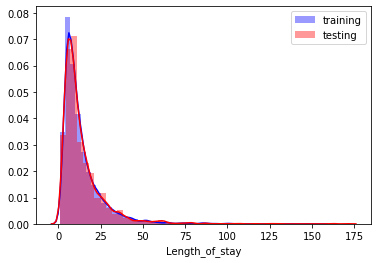

In [10]:
plt.figure()
sns.distplot(df_y_train['Length_of_stay'], color = 'blue')
sns.distplot(df_y_test['Length_of_stay'], color = 'red')
plt.legend(['training','testing'])

## 4. Extract non-time, 1day, 2day features from text files using pivots and aggregations (mean)

1. apply utility functions which tranform the long dataframe from the text files into a wide dataframe where each patient is represented with 1 row of data
2. for 1day and 2day dataframes, the time series features are aggregated into a single value - mean for day 1 or day 2 respectively. 


In [11]:
%%time

list_df_X_train_nontime = []
list_df_X_train_1day = []
list_df_X_train_2day = []

for file in train_files_list:
    df = pd.read_csv(os.path.join(train_dir,file))
    list_df_X_train_nontime.append(utils.extract_nontime_df(df, non_time_params))
    list_df_X_train_1day.append(utils.extract_day_df(df, unique_time_params, day = 1))
    list_df_X_train_2day.append(utils.extract_day_df(df, unique_time_params, day = 2))

list_df_X_test_nontime = []
list_df_X_test_1day = []
list_df_X_test_2day = []
    
for file in test_files_list:
    df = pd.read_csv(os.path.join(test_dir,file))
    list_df_X_test_nontime.append(utils.extract_nontime_df(df, non_time_params))
    list_df_X_test_1day.append(utils.extract_day_df(df, unique_time_params, day = 1))
    list_df_X_test_2day.append(utils.extract_day_df(df, unique_time_params, day = 2))

CPU times: user 3min 35s, sys: 4.36 s, total: 3min 39s
Wall time: 3min 41s


## 5. Concatenate patient data frames and merge columns to generate the training/testing features


In [12]:
df_X_train_nontime = pd.concat(list_df_X_train_nontime, axis = 0)
df_X_train_1day = pd.concat(list_df_X_train_1day, axis = 0)
df_X_train_2day = pd.concat(list_df_X_train_2day, axis = 0)

df_X_test_nontime = pd.concat(list_df_X_test_nontime, axis = 0)
df_X_test_1day = pd.concat(list_df_X_test_1day, axis = 0)
df_X_test_2day = pd.concat(list_df_X_test_2day, axis = 0)

In [13]:
df_X_train_nontime.head()

Parameter,Age,Gender,Height,ICUType,RecordID,Weight
0,35.0,0.0,-1.0,3.0,132592.0,71.8
0,42.0,1.0,-1.0,3.0,140662.0,138.1
0,61.0,1.0,188.0,2.0,140104.0,80.0
0,53.0,0.0,170.2,4.0,134685.0,96.1
0,46.0,1.0,-1.0,3.0,134849.0,-1.0


In [14]:
df_X_train_nontime.describe()

Parameter,Age,Gender,Height,ICUType,RecordID,Weight
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,64.247500,0.560750,88.919475,2.760000,137605.122000,74.75629
std,17.560946,0.497867,86.531203,1.002572,2923.608886,31.97107
min,15.000000,-1.000000,-1.000000,1.000000,132539.000000,-1.00000
25%,52.750000,0.000000,-1.000000,2.000000,135075.750000,62.00000
50%,67.000000,1.000000,152.400000,3.000000,137592.500000,76.20000
75%,78.000000,1.000000,170.200000,4.000000,140100.250000,90.42500
max,90.000000,1.000000,431.800000,4.000000,142673.000000,300.00000


#### Replace -1 for Height and Weight with Nan (for future imputation)

In [15]:
df_X_train_nontime['Height'] = df_X_train_nontime['Height'].replace(-1, np.nan)
df_X_train_nontime['Weight'] = df_X_train_nontime['Weight'].replace(-1, np.nan)
df_X_test_nontime['Height'] = df_X_test_nontime['Height'].replace(-1, np.nan)
df_X_test_nontime['Weight'] = df_X_test_nontime['Weight'].replace(-1, np.nan)

#### Merge dataframes - bring nontime features and target variables into the 1day and 2day features

In [16]:
df_train_nontime = pd.merge(df_X_train_nontime, df_y_train, on = 'RecordID')
df_train_1day = pd.merge(df_X_train_1day, df_train_nontime, on = 'RecordID')
df_train_2day = pd.merge(df_X_train_2day, df_train_nontime, on = 'RecordID')

df_test_nontime = pd.merge(df_X_test_nontime, df_y_test, on = 'RecordID')
df_test_1day = pd.merge(df_X_test_1day, df_test_nontime, on = 'RecordID')
df_test_2day = pd.merge(df_X_test_2day, df_test_nontime, on = 'RecordID')


# drop record ID columns
df_train_nontime.drop(['RecordID'],axis = 1, inplace = True)
df_train_1day.drop(['RecordID'],axis = 1, inplace = True)
df_train_2day.drop(['RecordID'],axis = 1, inplace = True)

df_test_nontime.drop(['RecordID'],axis = 1, inplace = True)
df_test_1day.drop(['RecordID'],axis = 1, inplace = True)
df_test_2day.drop(['RecordID'],axis = 1, inplace = True)

In [17]:
df_train_nontime.head()

,Age,Gender,Height,ICUType,Weight,Length_of_stay,Above_2_weeks
0,35.0,0.0,NaN,3.0,71.8,3,0
1,42.0,1.0,NaN,3.0,138.1,7,0
2,61.0,1.0,188.0,2.0,80.0,5,0
3,53.0,0.0,170.2,4.0,96.1,14,0
4,46.0,1.0,NaN,3.0,NaN,15,1


In [18]:
df_train_1day.head()

,SysABP,SaO2,HR,TroponinI,HCO3,PaO2,Cholesterol,MechVent,RespRate,NIMAP,...,Na,PaCO2,ALT,Age,Gender,Height,ICUType,Weight,Length_of_stay,Above_2_weeks
0,NaN,NaN,101.869565,NaN,15.166667,NaN,NaN,NaN,17.217391,79.515455,...,143.833333,NaN,NaN,35.0,0.0,NaN,3.0,71.8,3,0
1,NaN,NaN,124.636364,NaN,26.000000,85.0,NaN,1.0,NaN,86.833333,...,134.500000,42.0,34.0,42.0,1.0,NaN,3.0,138.1,7,0
2,98.387755,97.888889,96.448980,NaN,22.500000,179.0,NaN,1.0,NaN,61.242727,...,138.000000,44.4,NaN,61.0,1.0,188.0,2.0,80.0,5,0
3,NaN,NaN,70.782609,NaN,27.000000,NaN,NaN,NaN,NaN,78.947368,...,140.000000,NaN,NaN,53.0,0.0,170.2,4.0,96.1,14,0
4,NaN,NaN,95.032258,NaN,27.000000,NaN,NaN,NaN,21.266667,73.159630,...,138.000000,NaN,NaN,46.0,1.0,NaN,3.0,NaN,15,1


In [19]:
df_train_2day.head()

,SysABP,SaO2,HR,TroponinI,HCO3,PaO2,Cholesterol,MechVent,RespRate,NIMAP,...,Na,PaCO2,ALT,Age,Gender,Height,ICUType,Weight,Length_of_stay,Above_2_weeks
0,NaN,NaN,97.071429,NaN,15.625000,NaN,NaN,NaN,16.523810,80.925610,...,142.875000,NaN,NaN,35.0,0.0,NaN,3.0,71.8,3,0
1,NaN,NaN,118.239130,NaN,27.333333,85.25,NaN,1.0,NaN,90.045455,...,135.750000,42.25,34.0,42.0,1.0,NaN,3.0,138.1,7,0
2,97.852459,97.888889,93.400000,NaN,25.000000,179.00,NaN,1.0,NaN,62.062500,...,138.000000,44.40,NaN,61.0,1.0,188.0,2.0,80.0,5,0
3,NaN,NaN,70.739130,NaN,27.000000,NaN,NaN,NaN,NaN,80.658537,...,141.600000,NaN,NaN,53.0,0.0,170.2,4.0,96.1,14,0
4,NaN,NaN,96.048387,NaN,25.666667,NaN,NaN,NaN,19.918033,74.740517,...,137.333333,NaN,NaN,46.0,1.0,NaN,3.0,NaN,15,1


### Feature Exploration - nontime

/Users/x006814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/x006814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


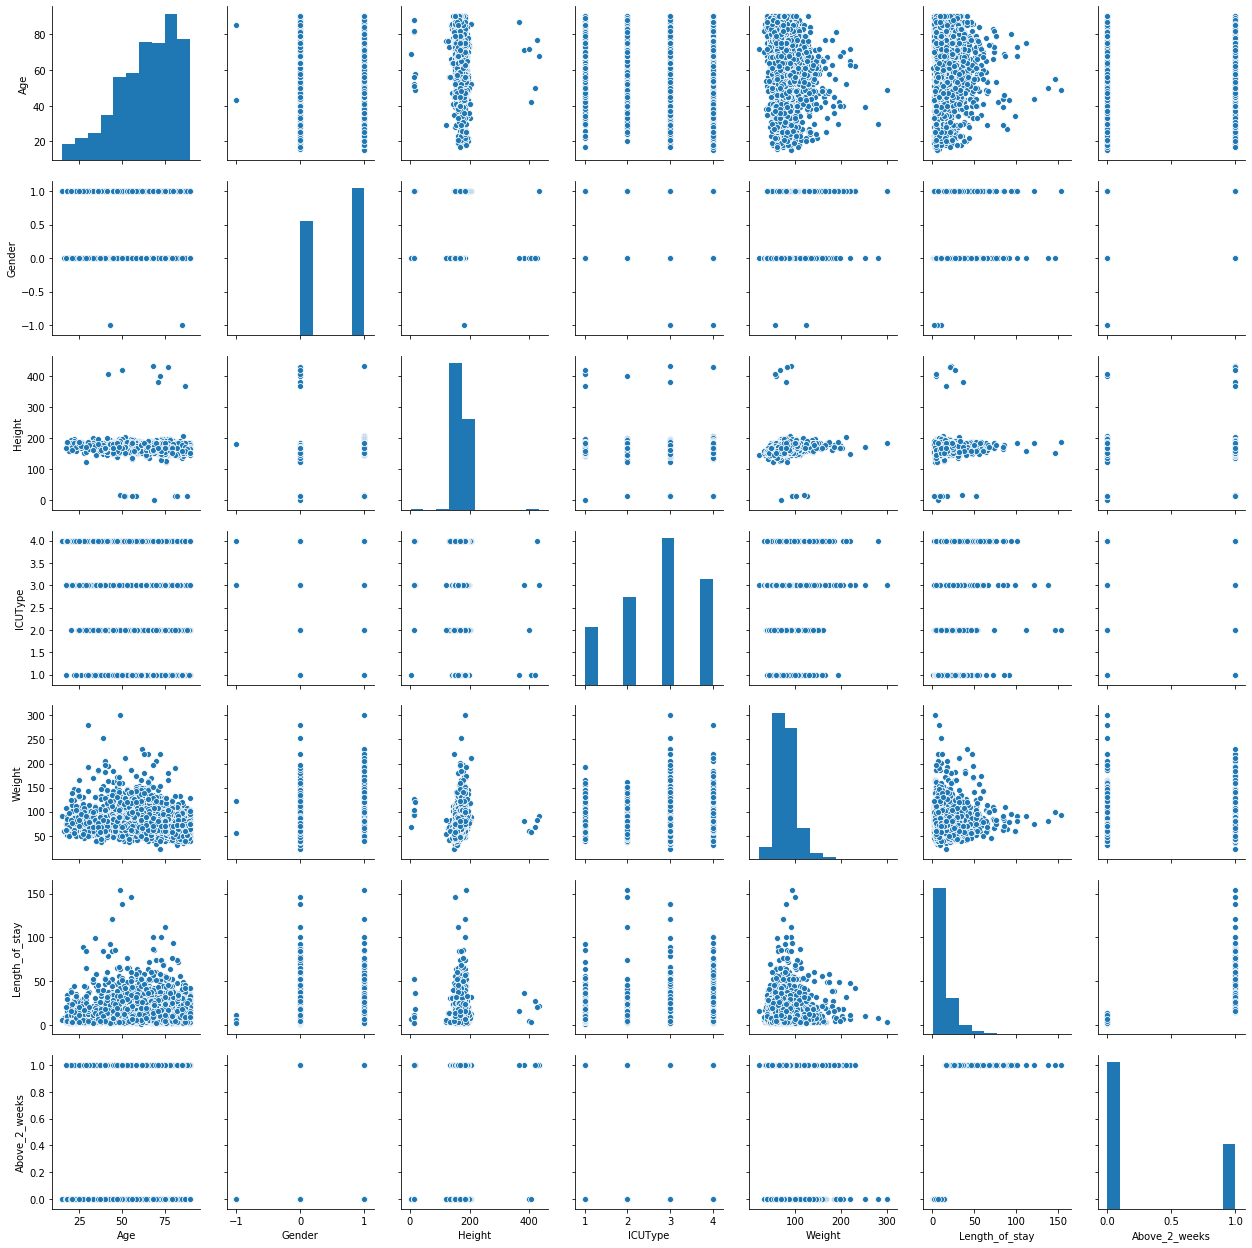

In [20]:
sns.pairplot(df_train_nontime)

## Feature Exploration - 1day

* Relatively weak linear correlation across the board

In [21]:
df_train_1day.corr()['Length_of_stay'].sort_values()

Albumin          -0.266717
GCS              -0.182530
Urine            -0.095347
Cholesterol      -0.094871
HCT              -0.094326
TroponinT        -0.073298
HCO3             -0.063886
PaO2             -0.043846
NISysABP         -0.043589
Age              -0.040141
MAP              -0.030609
PaCO2            -0.030226
Na               -0.021368
NIMAP            -0.019781
ALT              -0.018751
NIDiasABP        -0.013952
SaO2             -0.009786
AST              -0.007727
Mg               -0.006220
Platelets        -0.004138
pH               -0.003710
K                -0.000478
TroponinI         0.004225
Height            0.006959
SysABP            0.007547
Gender            0.009122
FiO2              0.016742
Glucose           0.017053
WBC               0.018495
DiasABP           0.022797
Weight            0.037328
Temp              0.038935
RespRate          0.041545
ALP               0.046436
Lactate           0.048821
Creatinine        0.063564
BUN               0.076455
B

## Feature Exploration - 2day

* Relatively weak linear correlation across the board

In [22]:
df_train_2day.corr()['Length_of_stay'].sort_values()

Albumin          -0.249438
GCS              -0.233934
HCT              -0.108844
Urine            -0.107665
HCO3             -0.078682
Cholesterol      -0.078120
PaO2             -0.072190
TroponinT        -0.045899
NISysABP         -0.044717
SaO2             -0.041248
Age              -0.040141
PaCO2            -0.035491
TroponinI        -0.034126
MAP              -0.028787
NIMAP            -0.024003
NIDiasABP        -0.021095
ALT              -0.016703
FiO2             -0.011606
AST              -0.011366
Platelets        -0.010992
Na               -0.007156
SysABP            0.001460
pH                0.005977
K                 0.006596
Height            0.006959
Mg                0.006979
Gender            0.009122
DiasABP           0.019398
WBC               0.019635
Lactate           0.022220
RespRate          0.023824
Glucose           0.026219
ALP               0.034127
Weight            0.037328
Temp              0.049816
Bilirubin         0.069805
Creatinine        0.070486
B

## 6. Drop excessive Nan columns (drop columns > 35% missing)

### nontime

In [23]:
missing_value_df_nontime = utils.get_null_percentages(df_train_nontime)
missing_value_df_nontime

,column_name,percent_missing
Height,Height,47.106599
Weight,Weight,7.969543
Age,Age,0.000000
Gender,Gender,0.000000
ICUType,ICUType,0.000000
Length_of_stay,Length_of_stay,0.000000
Above_2_weeks,Above_2_weeks,0.000000


In [30]:
nontime_col_filtered = list(missing_value_df_nontime[missing_value_df_nontime['percent_missing'] < 35]['column_name'])
df_train_nontime = df_train_nontime[nontime_col_filtered]
df_test_nontime = df_test_nontime[nontime_col_filtered]

### 1day

In [25]:
missing_value_df_1day = utils.get_null_percentages(df_train_1day)
missing_value_df_1day

,column_name,percent_missing
TroponinI,TroponinI,95.355330
Cholesterol,Cholesterol,93.299492
TroponinT,TroponinT,79.289340
RespRate,RespRate,72.766497
Albumin,Albumin,66.878173
ALP,ALP,62.817259
Bilirubin,Bilirubin,62.715736
ALT,ALT,62.131980
AST,AST,62.055838
SaO2,SaO2,61.979695


In [31]:
day1_col_filtered = list(missing_value_df_1day[missing_value_df_1day['percent_missing'] < 35]['column_name'])
df_train_1day = df_train_1day[day1_col_filtered]
df_test_1day = df_test_1day[day1_col_filtered]

### 2day

In [32]:
missing_value_df_2day = utils.get_null_percentages(df_train_2day)
missing_value_df_2day

,column_name,percent_missing
FiO2,FiO2,31.878173
MAP,MAP,30.076142
DiasABP,DiasABP,29.923858
SysABP,SysABP,29.923858
PaO2,PaO2,24.086294
PaCO2,PaCO2,24.086294
pH,pH,23.654822
NIMAP,NIMAP,12.969543
NIDiasABP,NIDiasABP,12.918782
NISysABP,NISysABP,12.664975


In [33]:
day2_col_filtered = list(missing_value_df_2day[missing_value_df_2day['percent_missing'] < 35]['column_name'])
df_train_2day = df_train_2day[day2_col_filtered]
df_test_2day = df_test_2day[day2_col_filtered]

### output datasets for dataiku 

In [34]:
df_train_nontime.to_csv('data/df_train_nontime.csv', index = False)
df_train_1day.to_csv('data/df_train_1day.csv', index = False)
df_train_2day.to_csv('data/df_train_2day.csv', index = False)

In [35]:
df_test_nontime.to_csv('data/df_test_nontime.csv', index = False)
df_test_1day.to_csv('data/df_test_1day.csv', index = False)
df_test_2day.to_csv('data/df_test_2day.csv', index = False)